## This notebook is wave propagating between two sections

solves Euler equations

the first section has constant velocity and constant enthalpy inflow

still working on this

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
cd(dirname(pwd()))
cd("src")
include("Tools.jl")
include("FiniteDifference.jl")
include("TimeMarching.jl")
include("Initial.jl")
include("Systems.jl")
include("BoundaryCondition.jl")

using ..Tools
using ..FiniteDifference
using ..TimeMarching
using ..Initial
using ..Systems
using ..BoundaryCondition
pwd()

"C:\\Users\\liyux\\github\\thermo-network\\src"

## Parameters for the RHS

In [3]:
P=1;
Ac=1; # unreal
qw=0;

righthand=[0;0;P/Ac*qw]

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

## Initialization (wave)

In [4]:
    # Initial spacial variables
    nx = 201   
    gamma = 1.4
    xlim = (0.0,1.0)
    Δx = (xlim[2]-xlim[1])/nx
    ux1,uu1=Initial.initial_one_wave(nx,xlim,gamma,0.5)
    ux2,uu2=Initial.initial_uniform(nx,xlim,gamma)

    # set ShockTubeSystem structs
    sys1=Systems.ShockTubeSystem(gamma,Δx)
    sys2=Systems.ShockTubeSystem(gamma,Δx)
    # get every property from the initial uu
    uueverythinginitial1=Systems.UUtoEverything(uu1,sys1)
    uueverythinginitial2=Systems.UUtoEverything(uu2,sys2)
    # Initial time and storage arrays
    t = 0.0
    thist = []
    uhist1 = []
    uhist2 = []


0-element Array{Any,1}

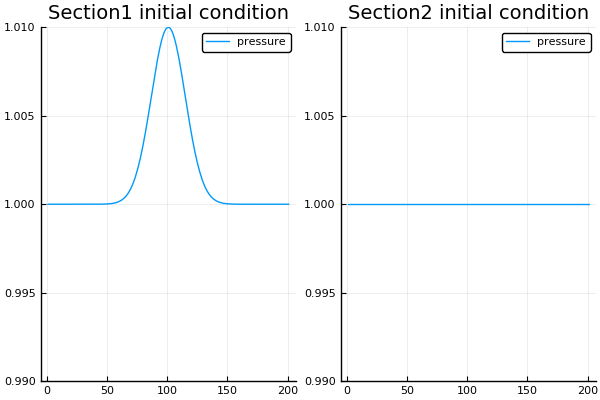

In [5]:
plot([uueverythinginitial1.p,uueverythinginitial2.p], ylim=(2-maximum(uueverythinginitial1.p),maximum(uueverythinginitial1.p)), title=["Section1 initial condition" "Section2 initial condition"],label=["pressure" "pressure"],  layout = (1, 2))


## Time Marching (with boundary condition)


In [6]:
    Δt = 0.0001

    println("Δx=",Δx);
    println("Δt=",Δt);



    #Calculation time
    tf = 2
    tsample = tf/400;
    T = Δt:Δt:tf

    # Push it with time!
    for ti in T
        
        # Time marching
        t, uu1 = TimeMarching.stegerwarmingrk1!(t-Δt,uu1,righthand,sys1,Δt)
        t, uu2 = TimeMarching.stegerwarmingrk1!(t-Δt,uu2,righthand,sys2,Δt)
        t=t+Δt
        
        # Set the boundary at the interface to make a close tube
        uu2[:,1]=set_inlet_interface!(uu1::Array,uu2::Array,sys1,sys2,Δt::Float64)
        uu1[:,end]=set_outlet_interface!(uu1::Array,uu2::Array,sys1,sys2,Δt::Float64)
        uu1[:,1]=set_inlet_interface!(uu2::Array,uu1::Array,sys2,sys1,Δt::Float64)
        uu2[:,end]=set_outlet_interface!(uu2::Array,uu1::Array,sys2,sys1,Δt::Float64)

    
        # get every property from uu in every time step
        uueverything1=Systems.UUtoEverything(uu1,sys1)
        uueverything2=Systems.UUtoEverything(uu2,sys2)
    
    
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(thist,deepcopy(t)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist1,deepcopy(uueverything1)) : nothing
        (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist2,deepcopy(uueverything2)) : nothing
       
    end

    

Δx=0.004975124378109453
Δt=0.0001


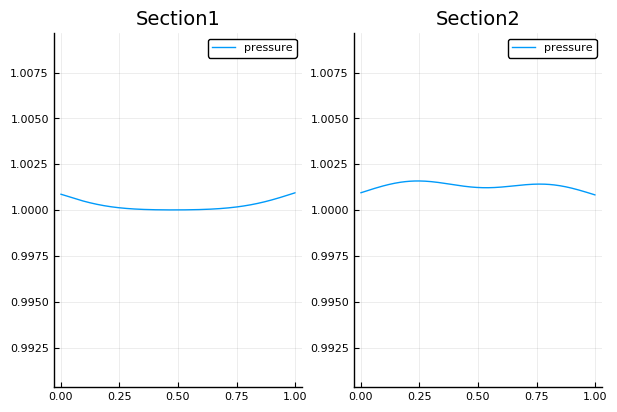

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\github\thermo-network\src\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\B2J6j\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\liyux\\github\\thermo-network\\src\\tmp.gif")
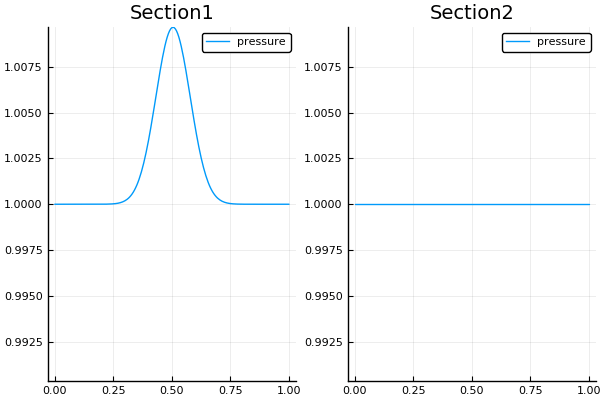

In [8]:
@gif for i in 1:length(uhist1)
    plot([ux1 ux2], [uhist1[i].p,uhist2[i].p], ylim=(2-maximum(uhist1[1].p),maximum(uhist1[1].p)), title=["Section1" "Section2"],label=["pressure" "pressure"],  layout = (1, 2))
#     plot([uhist1[i].u,uhist2[i].u], ylim=(2-maximum(uhist1[1].u),maximum(uhist1[1].u)), title=["Section1" "Section2"],label=["pressure" "pressure"],  layout = (1, 2))
#     plot([uhist1[i].ρ,uhist2[i].ρ], ylim=(0.25-maximum(uhist1[1].ρ),maximum(uhist1[1].ρ)), title=["Section1" "Section2"],label=["pressure" "pressure"],  layout = (1, 2))
#     plot([uhist1[i].h,uhist2[i].h], ylim=(0.998 .* minimum(uhist1[1].h), 1.002 .* maximum(uhist1[1].h)), title=["Section1" "Section2"],label=["pressure" "pressure"],  layout = (1, 2))
end